In [1]:
# This code works in Python 3.10.6
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
import import_ipynb
#PubMed dataset with all features
import pubmed_dataset

importing Jupyter notebook from pubmed_dataset.ipynb
HeteroData(
  disease={
    x=[454, 200],
    y=[454],
    train_mask=[454],
    val_mask=[454],
    test_mask=[454]
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)


In [3]:
data = pubmed_dataset.data

In [4]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['disease'])


model = HeteroGNN(data.metadata(), hidden_channels=256, out_channels=8,
                  num_layers=4)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['disease'].train_mask
    loss = F.cross_entropy(out[mask], data['disease'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['disease'][split]
        acc = (pred[mask] == data['disease'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 1.0994, Train: 0.6824, Val: 0.4853, Test: 0.4559
Epoch: 020, Loss: 0.2095, Train: 0.9591, Val: 0.5000, Test: 0.5735
Epoch: 030, Loss: 0.0109, Train: 1.0000, Val: 0.4706, Test: 0.5588
Epoch: 040, Loss: 0.0241, Train: 0.9434, Val: 0.4559, Test: 0.4853
Epoch: 050, Loss: 0.0324, Train: 0.9969, Val: 0.5000, Test: 0.5147
Epoch: 060, Loss: 0.0147, Train: 1.0000, Val: 0.4559, Test: 0.5000
Epoch: 070, Loss: 0.0045, Train: 1.0000, Val: 0.4706, Test: 0.4559
Epoch: 080, Loss: 0.0021, Train: 1.0000, Val: 0.4853, Test: 0.4559
Epoch: 090, Loss: 0.0023, Train: 1.0000, Val: 0.4853, Test: 0.4559
Epoch: 100, Loss: 0.0027, Train: 1.0000, Val: 0.4706, Test: 0.4559


In [5]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [6]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [7]:
all_edges = {}

In [8]:
def create_dataset(nodes,edges,disease_df,gene_df,chemical_df,species_df,node_id,df_graph):
    disease = np.asarray(disease_df.drop(columns=['class']))
    gene = np.asarray(gene_df)
    chemical = np.asarray(chemical_df)
    species = np.asarray(species_df)
    

    x_disease = torch.tensor(disease).to(dtype=torch.float32)
    y_disease = torch.tensor(np.array(disease_df["class"]), dtype=torch.long)
    x_gene = torch.tensor(gene).to(dtype=torch.float32)
    x_chemical = torch.tensor(chemical).to(dtype=torch.float32)
    x_species = torch.tensor(species).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    gene_to_gene = []
    gene_to_disease = []
    disease_to_disease = []
    chemical_to_gene = []
    chemical_to_disease = []
    chemical_to_chemical = []
    chemical_to_species = []
    species_to_gene = []
    species_to_disease = []
    species_to_species = []
    remaining_edges = []

    class_dict = {'Gene':0, 'Disease':1, 'Chemical':2,'Species':3}

    for i in range(len(edges)):

        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Gene']) and \
        (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                gene_to_gene.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Gene']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Disease']):
                gene_to_disease.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Disease']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Disease']):
                disease_to_disease.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                chemical_to_gene.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Disease']):
                chemical_to_disease.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0]== class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Chemical']):
                chemical_to_chemical.append((int(source[i]),int(dest[i])))
                
        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Species']):
                chemical_to_species.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Species']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                species_to_gene.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Species']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Disease']):
                species_to_disease.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0]== class_dict['Species']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Species']):
                species_to_species.append((int(source[i]),int(dest[i])))

        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*gene_to_gene,*gene_to_disease,*disease_to_disease,*chemical_to_gene,
                          *chemical_to_disease,*chemical_to_chemical,*chemical_to_species, *species_to_gene, 
                          *species_to_disease, *species_to_species]
            
    disease = list(df_graph[df_graph['class'] == 1]['nodeId'])
    disease = [int(i) for i in disease]
    disease_nodes_mapping = remap_indices(disease)
    
    gene = list(df_graph[df_graph['class'] == 0]['nodeId'])
    gene = [int(i) for i in gene]
    gene_nodes_mapping = remap_indices(gene)
    
    chemical = list(df_graph[df_graph['class'] == 2]['nodeId'])
    chemical = [int(i) for i in chemical]
    chemical_nodes_mapping = remap_indices(chemical)
    
    species = list(df_graph[df_graph['class'] == 3]['nodeId'])
    species = [int(i) for i in species]
    species_nodes_mapping = remap_indices(species)


    node_list = {}
    for d in [disease_nodes_mapping, gene_nodes_mapping, chemical_nodes_mapping,species_nodes_mapping]:
        node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'disease':{'x': x_disease, 'y':y_disease}, 'gene':{'x': x_gene},
                              'chemical':{'x': x_chemical}, 'species':{'x': x_species}})

    if gene_to_gene:
        edge_index_gene_gene = preprocess_edges(gene_to_gene,node_list)
        small_graph['gene','to','gene'].edge_index = edge_index_gene_gene
    if gene_to_disease:
        edge_index_gene_disease = preprocess_edges(gene_to_disease,node_list)
        small_graph['gene','to','disease'].edge_index = edge_index_gene_disease
    if disease_to_disease:
        edge_index_disease_disease = preprocess_edges(disease_to_disease,node_list)
        small_graph['disease','to','disease'].edge_index = edge_index_disease_disease
    if chemical_to_gene:
        edge_index_chemical_gene = preprocess_edges(chemical_to_gene,node_list)
        small_graph['chemical','to','gene'].edge_index = edge_index_chemical_gene
    if chemical_to_disease:
        edge_index_chemical_disease = preprocess_edges(chemical_to_disease,node_list)
        small_graph['chemical','to','disease'].edge_index = edge_index_chemical_disease
    if chemical_to_chemical:
        edge_index_chemical_chemical = preprocess_edges(chemical_to_chemical,node_list)
        small_graph['chemical','to','chemical'].edge_index = edge_index_chemical_chemical
    if chemical_to_species:
        edge_index_chemical_species = preprocess_edges(chemical_to_species,node_list)
        small_graph['chemical','to','species'].edge_index = edge_index_chemical_species
    if species_to_gene:
        edge_index_species_gene = preprocess_edges(species_to_gene,node_list)
        small_graph['species','to','gene'].edge_index = edge_index_species_gene
    if species_to_disease:
        edge_index_species_disease = preprocess_edges(species_to_disease,node_list)
        small_graph['species','to','disease'].edge_index = edge_index_species_disease
    if species_to_species:
        edge_index_species_species = preprocess_edges(species_to_species,node_list)
        small_graph['species','to','species'].edge_index = edge_index_species_species

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph

In [9]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['disease'].test_mask
        correct = (pred[mask] == small_graph['disease'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['disease'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [10]:
def get_real_graph(size):
    real_graph = nx.Graph()
    if(size <= 5):
        real_graph = nx.read_gexf(real_graph_path+'real_G5.gexf')
    elif(size <= 10):
        real_graph = nx.read_gexf(real_graph_path+'real_G10.gexf')
    elif(size <= 15):
        real_graph = nx.read_gexf(real_graph_path+'real_G15.gexf')
    elif(size <= 20):
        real_graph = nx.read_gexf(real_graph_path+'real_G20.gexf')
    elif(size <= 25):
        real_graph = nx.read_gexf(real_graph_path+'real_G25.gexf')
    elif(size <= 30):
        real_graph = nx.read_gexf(real_graph_path+'real_G30.gexf')
    elif(size <= 35):
        real_graph = nx.read_gexf(real_graph_path+'real_G35.gexf')


    return real_graph

In [11]:
import os
import glob

softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
rootdir = '../syn_vae/pubmed/'

real_graph_path = '../real_graphs/pubmed/'
dir_list = []
for subdir, dirs,files in os.walk(rootdir):
    
    if files:
        graph_path = os.path.join(subdir, files[0])
        class_path = os.path.join(subdir, files[1])       
        feature_path = os.path.join(subdir, files[2])

        graph = nx.read_gexf(graph_path)
        filename = os.path.basename(graph_path)
        graph_id= filename.split('.')[0]
            #print(graph_id)

        nodeId_list = []

        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            edges = [e for e in graph.edges]

        node_type_list = torch.load(class_path).detach().numpy()

        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list


        df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
        df_feature["class"] = node_type_list
    
        real_graph = get_real_graph(len(nodeId_list))

        node_label_list = []

        if not (nx.get_node_attributes(real_graph, "class") is None):
            node_class = nx.get_node_attributes(real_graph, "class")
            node_label_list.append(node_class.get('1'))

        disease_node_features = df_feature[df_feature['class'] == 1].drop(['class'], axis = 1)

        if not (None in node_label_list):
                
            labels = []
            unique_labels = list(set(node_label_list))
                
            for i in range(0,len(disease_node_features)):
                labels.append(random.choice(unique_labels))

            disease_node_features['class']= labels

            gene_node_features = df_feature[df_feature['class'] == 0].drop(['class'], axis = 1)
            chemical_node_features = df_feature[df_feature['class'] == 2].drop(['class'], axis = 1)
            species_node_features = df_feature[df_feature['class'] == 3].drop(['class'], axis = 1)



            small_graph_data = create_dataset(nodeId_list,edges,
                                      disease_node_features,gene_node_features,
                                      chemical_node_features,species_node_features,graph_id,df_graph)

            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):


                if (small_graph_data['disease'].x.nelement()!=0) and \
                (small_graph_data['gene','to','gene']) and \
                (small_graph_data['chemical','to','gene']) and \
                (small_graph_data['chemical','to','chemical']) and \
                (small_graph_data['chemical','to','disease']) and \
                (small_graph_data['gene','to','disease']) and \
                (small_graph_data['species','to','disease']) and \
                (small_graph_data['chemical','to','species']):
                    print(graph_path)
                    softmax, correct_indices = evaluate_gnn(small_graph_data)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'gene':small_graph_data['gene'].x,
                                                 'disease':small_graph_data['disease'].x[correct_indices],
                                                 'chemical':small_graph_data['chemical'].x,
                                                  'species':small_graph_data['species'].x}
                    graph_dict[graph_id]=df_graph

        
        

../syn_vae/pubmed/sync652879203651/sync652879203651_G23.gexf
HeteroData(
  disease={
    x=[5, 200],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  gene={ x=[6, 200] },
  chemical={ x=[3, 200] },
  species={ x=[5, 200] },
  (gene, to, gene)={ edge_index=[2, 3] },
  (gene, to, disease)={ edge_index=[2, 3] },
  (disease, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 1] },
  (chemical, to, disease)={ edge_index=[2, 1] },
  (chemical, to, chemical)={ edge_index=[2, 2] },
  (chemical, to, species)={ edge_index=[2, 4] },
  (species, to, gene)={ edge_index=[2, 2] },
  (species, to, disease)={ edge_index=[2, 1] }
)
Prediction: tensor([6, 1, 1, 3, 6])
Ground Truth: tensor([6, 6, 6, 6, 6])
tensor([ True, False, False, False,  True])
tensor([[1.2855e-02, 5.0109e-05, 7.3035e-04, 3.8001e-03, 1.6609e-03, 1.1484e-03,
         9.5386e-01, 2.5898e-02],
        [1.0202e-02, 7.2595e-01, 5.1897e-04, 2.5743e-01, 1.3152e-05, 5.8652e-03,
         1.033

../syn_vae/pubmed/sync679095203622/sync679095203622_G22.gexf
HeteroData(
  disease={
    x=[3, 200],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  gene={ x=[5, 200] },
  chemical={ x=[5, 200] },
  species={ x=[7, 200] },
  (gene, to, gene)={ edge_index=[2, 1] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (disease, to, disease)={ edge_index=[2, 2] },
  (chemical, to, gene)={ edge_index=[2, 1] },
  (chemical, to, disease)={ edge_index=[2, 1] },
  (chemical, to, chemical)={ edge_index=[2, 4] },
  (chemical, to, species)={ edge_index=[2, 6] },
  (species, to, gene)={ edge_index=[2, 3] },
  (species, to, disease)={ edge_index=[2, 1] }
)
Prediction: tensor([3, 1, 5])
Ground Truth: tensor([6, 6, 6])
tensor([False, False, False])
tensor([[5.9554e-03, 2.4864e-01, 3.7531e-04, 7.3749e-01, 8.7465e-06, 7.4980e-03,
         2.5269e-07, 3.3043e-05],
        [9.6826e-05, 9.9981e-01, 9.2740e-06, 7.6341e-05, 6.9583e-07, 8.3428e-06,
         2.9874e-11, 2.2349e-08],
      

In [12]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  9


In [13]:
#Getting the list of predictions for each class
prob_class6_dict = {}
for nodeid in softmax_dict:
    
    if len(softmax_dict[nodeid]) > 0:
        list6= []

        for prob in softmax_dict[nodeid]:        
            list6.append(prob[6])


     #Taking max probability of all nodes of each class in a graph

    if len(list6) != 0:
        prob_class6_dict[nodeid]=max(list6)


In [14]:
max_pred6 = max(prob_class6_dict.values())
class6_graphid = max(prob_class6_dict, key=prob_class6_dict.get)
print(class6_graphid)

sync652879203651_G23


In [15]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

Plotting explanation graph with node features for each class of Disease node

Node colors:

Gene - Blue

Disease - Red

Chemical - Darkgreen

Species - Orange

Number of nodes:  19
graph id:  sync652879203651_G23
Max pred probability for class 6 is 0.9538571238517761


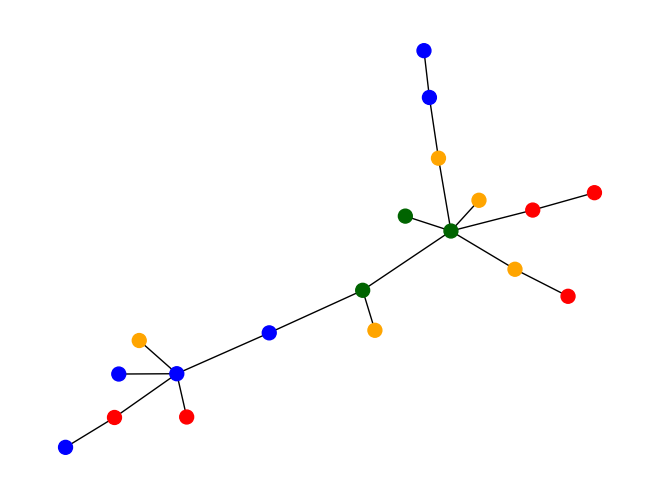

In [17]:
explanation_graph6 = plot_graph(class6_graphid, max_pred6, 6, all_edges[class6_graphid],graph_dict[class6_graphid])

In [18]:
def print_stat_cont_features(df):
    #print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [19]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [20]:
gene6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['gene'].numpy())
print_stat_cont_features(gene6_df)

mean -0.0014823081
std dev 0.099710144


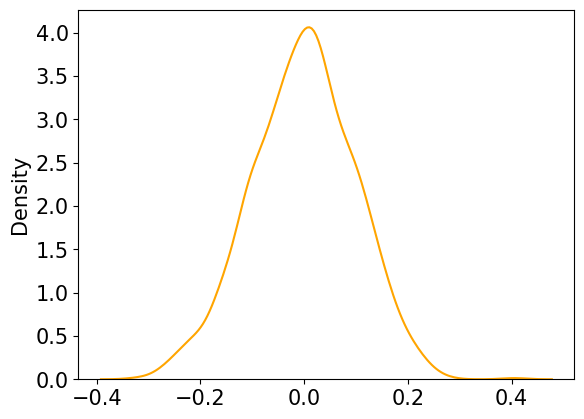

In [21]:
plot_node_feat(gene6_df)

In [22]:
disease6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['disease'].numpy())
print_stat_cont_features(disease6_df)

mean -0.00040654332
std dev 0.098345965


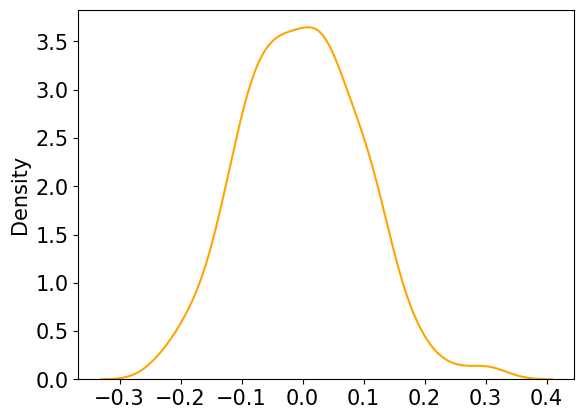

In [23]:
plot_node_feat(disease6_df)

In [24]:
chemical6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['chemical'].numpy())
print_stat_cont_features(chemical6_df)

mean -0.0041787215
std dev 0.10129695


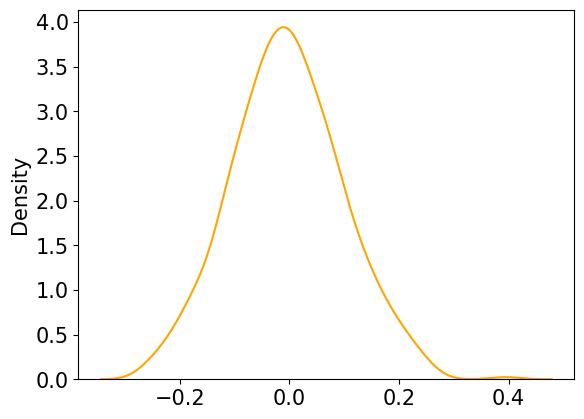

In [25]:
plot_node_feat(chemical6_df)

In [26]:
species6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['species'].numpy())
print_stat_cont_features(species6_df)

mean -0.0024752507
std dev 0.10330824


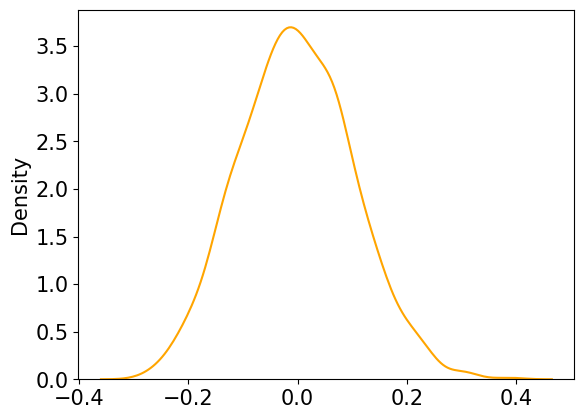

In [27]:
plot_node_feat(species6_df)